In [1]:
import numpy as np
import pickle
import cv2
from matplotlib import pyplot as plt
from os import listdir, remove, walk
from os.path import isfile, join, abspath
import requests
import time
import PIL
from PIL import ImageFilter
import sys
from keras.models import load_model
from scipy.ndimage import gaussian_filter
import json
from matplotlib.patches import Rectangle

Using TensorFlow backend.
/home/miguel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/miguel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/miguel/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/miguel/.local/lib/python3.7/site-packages/tensorflow/python

In [10]:
def _load_latents_recursive(latents, filenames, cur_local_dir, latents_dir):
    for f in listdir(latents_dir):
        file = join(latents_dir, f)
        if isfile(file):
            if file.endswith(".npy"):
                filenames.append(cur_local_dir + f)
                latents.append(np.load(file)[np.newaxis,])
        else:
            latents, filenames = _load_latents_recursive(latents, filenames, cur_local_dir + f + '/', file )
        
    return latents, filenames


def load_latents(latents_dir, recursive=False):
    latents = []
    filenames = []
    if recursive:
        return _load_latents_recursive(latents, filenames, '', latents_dir)
    
    for f in listdir(latents_dir):
        file = join(latents_dir, f)
        if isfile(file) and file.endswith(".npy"):
            filenames.append(f)
            latents.append(np.load(file)[np.newaxis,])
    

    return latents, filenames

 
def load_latents_dict(latents_dir, recursive=False):
    latents, filenames = load_latents(latents_dir, recursive)
    crop = pickle.load(open(join(latents_dir, "crops.pickle"),"rb"))
    #if len(latents) != len(crop.keys()):
    #    raise Exception("The number of crops does not match with the number of latent files!")
    return {'Latent': latents, 'Filenames': filenames, 'Path':latents_dir, 'Crop':crop}

## Para generar las latentes se utiliza stylegan2encoder

Es importante utilizar el entorno virtual de ese proyecto. Puede dar problemas la versión de CUDA y gcc.

### Para alinear las imágenes 
```bash
# align_images.py input_folder output_folder. input_folder contiene todas las imagenes que queramos codificar, y serán descartadas si son pequeñas. Es recursivo, pillará también los subdirectorios.
python3.7 align_images.py ./raw_images ./aligned_images/
```

### Para codificar las latentes
```bash
# encode_images.py input_folder output_folder_images output_folder_latents. El input es el output de align_images.py.
LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64 python3.7 encode_images.py aligned_images/ generated_images/ latent_representations/
```

In [11]:
# Crea un archivo con todo lo necesario para las latentes, como lo quiere StyleFlow
latents = load_latents_dict("/home/miguel/Desktop/TFM/stylegan2encoder/latent_representations", True)
pickle.dump(latents, open('sg2latents.pickle', 'wb'))

In [2]:
sg2latentfile = open('sg2latents.pickle', 'rb')
sg2latent = pickle.load(sg2latentfile)

In [14]:
def generate_and_save_linear_TSNE(num_points):
    lin = np.linspace(0.05, 0.65, num_points)[np.newaxis,].T
    np.save("TSNE.npy", np.hstack((lin, lin)))
    
generate_and_save_linear_TSNE(len(latents['Latent']))

In [15]:
# Necesitas tu propia clave de Microsoft faces y tu endpoint.
MICROFT_FACES_API_KEY = '2a0fc6b886294e518516d613e267d2e5'
ENDPOINT = 'https://yourendpoint.cognitiveservices.azure.com'

def get_image_attributes(root_dir, image_local_paths):
    
    print("This will generate", len(latents['Latent']), "calls to the Microsoft faces API. Are you sure you want to procced? (y/n): ", end="")
    res = input()
    if res.lower() != "y" and res.lower() != "yes":
        return None
    
    attributes = np.zeros((len(latents['Latent']), 8, 1))
    
    
    for idx, img in enumerate(image_local_paths):
        full_path = root_dir + '/' + img
        full_path = full_path.split(".")[0] + ".png"
        
        headers = {
            'Content-Type': 'application/octet-stream',
            'Ocp-Apim-Subscription-Key': MICROFT_FACES_API_KEY,
        }

        body = open(full_path, 'rb')
        # Request URL 
        FaceApiDetect = ENDPOINT + '/face/v1.0/detect?returnFaceId=true&returnFaceAttributes=age,gender,glasses,headPose,smile,facialHair,hair' 
        try:
            # REST Call
            response = requests.post(FaceApiDetect, data=body, headers=headers) 
            response = response.json()[0]['faceAttributes']
            
            attributes[idx,0,0] = 1 if response['gender'] == "male" else 0 # Gender
            attributes[idx,1,0] = 0 if response['glasses'] == "NoGlasses" else 1 # Glasses
            attributes[idx,2,0] = response['headPose']['yaw'] # Yaw
            attributes[idx,3,0] = response['headPose']['pitch'] # Pitch
            attributes[idx,4,0] = response['hair']['bald'] # Baldness
            attributes[idx,5,0] = response['facialHair']['beard'] # Beard
            attributes[idx,6,0] = response['age'] # Age
            attributes[idx,7,0] = response['smile'] # Expression
            
        except Exception as e:
            print(e)
            print("Error on image", full_path, "... Attributes will be all set to 0 on said image. Resuming...")
        
        # 20 calls per minute limit
        time.sleep(3)
        
    return attributes
    
attributes = get_image_attributes("/home/miguel/Desktop/TFM/stylegan2encoder/generated_images", latents['Filenames'])

This will generate 276 calls to the Microsoft faces API. Are you sure you want to procced? (y/n): y


In [16]:
# ['Gender', 'Glasses', 'Yaw', 'Pitch', 'Baldness', 'Beard', 'Age', 'Expression']
np.save("attributes.npy", attributes)

### Las luces se generan con el repositorio DPR. Usar:
```bash
# --latents es el archivo generado con este notebook --save_dir donde se guardan las luces (debe estar en la carpeta data de StyleFlow), el ultimo argumento son las imagenes de las que predecimos las luces. Esto también se hace recursivo.
python getLightning.py --latents /home/miguel/Desktop/TFM/StyleFlow/data/sg2latents.pickle --save_dir /home/miguel/Desktop/TFM/StyleFlow/data/ /home/miguel/Desktop/TFM/stylegan2encoder/generated_images/
```

El entorno virtual general de datasets sirve. 

### Para crear las luces modificadas se utiliza en StyleFlow
```shell
sudo docker-compose up --build
```

Se puede acceder al contenedor con:

```shell
sudo docker run -i -t id_imagen /bin/bash
```

### Para ejecutar manualmente el comando de modificar las luces se utiliza dentro del contenedor
```shell
# No estoy seguro de que no haya cambiado como funciona. --source-dir es la carpeta de las latentes, --max-num-light changes es el número de luces que se cambia, y --max-light-change el valor máximo del cambio entre 0 y 1. Mirar el código porque puede que haya sido cambiado el uso de estas variables para la versión final.
python3.7 /usr/app/run_generator.py style-changing --network=gdrive:networks/stylegan2-ffhq-config-f.pkl --source-dir /home/miguel/Desktop/TFM/stylegan2encoder/latent_representations --num-changes 5 --max-num-light-changes 1 --max-light-change 0.4 --result-dir /usr/app/results
```

### Para traerse los resultados del contendedor
```shell
sudo docker ps -aqf "name=styleflow_interface"
sudo docker cp 648ce657b461:/usr/app/results /home/miguel/Desktop/TFM/StyleFlow
```
También se puede utilizar -v en docker para montar una carpeta experna y poner los resultados ahí directamente.

In [65]:
sg2latentfile = open('sg2latents.pickle', 'rb')
sg2latents = pickle.load(sg2latentfile)

In [66]:
sg2latents['Latent'][0].shape


(1, 18, 512)

(1024, 1391)


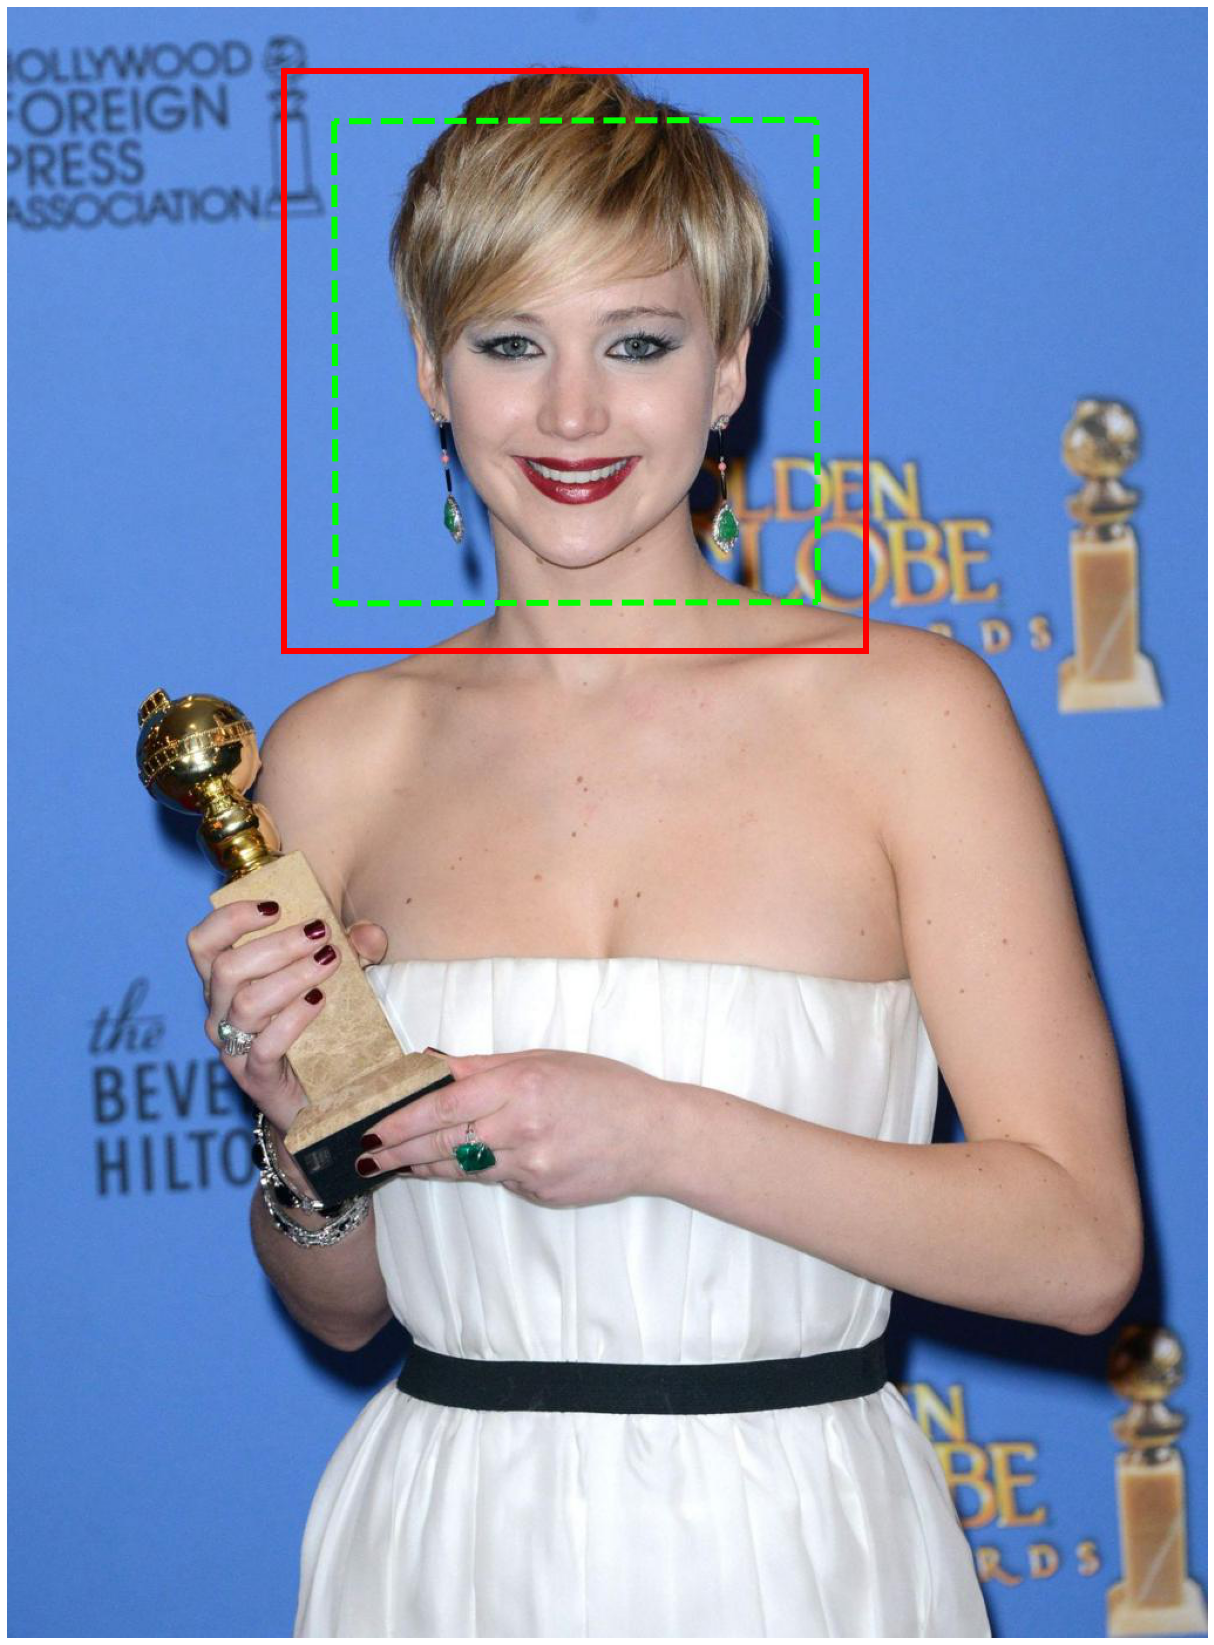

In [64]:
#/home/miguel/Desktop/presentacion/16_Award_Ceremony_Awards_Ceremony_16_501.jpg
'''
# Este código es para generar imágenes para la memoria
cr = sg2latents['Crop']['16_Award_Ceremony_Awards_Ceremony_16_501_01']['crop']
qd = sg2latents['Crop']['16_Award_Ceremony_Awards_Ceremony_16_501_01']['quad']
qdx = qd[:,0]
qdy = qd[:,1]

img = PIL.Image.open("/home/miguel/Desktop/presentacion/16_Award_Ceremony_Awards_Ceremony_16_501.jpg")
print(img.size)
fig = plt.figure(frameon=False, figsize=(30,30),)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax = plt.imshow(img)
ax = plt.plot([cr[0], cr[2]], [cr[1], cr[1]], c="red", linewidth=6)
ax = plt.plot([cr[0], cr[0]], [cr[1], cr[3]], c="red", linewidth=6)
ax = plt.plot([cr[2], cr[0]], [cr[3], cr[3]], c="red", linewidth=6)
ax = plt.plot([cr[2], cr[2]], [cr[1], cr[3]], c="red", linewidth=6)
ax = plt.plot([qdx[0] + cr[0], qdx[1] + cr[0]], [qdy[0]+ cr[1], qdy[1]+ cr[1]], c="lime", linewidth=6, linestyle='--')
ax = plt.plot([qdx[1] + cr[0], qdx[2] + cr[0]], [qdy[1]+ cr[1], qdy[2]+ cr[1]], c="lime", linewidth=6, linestyle='--')
ax = plt.plot([qdx[2] + cr[0], qdx[3] + cr[0]], [qdy[2]+ cr[1], qdy[3]+ cr[1]], c="lime", linewidth=6, linestyle='--')
ax = plt.plot([qdx[3] + cr[0], qdx[0] + cr[0]], [qdy[3]+ cr[1], qdy[0]+ cr[1]], c="lime", linewidth=6, linestyle='--')
plt.axis('off')
#fig.add_axes(ax)
fig.savefig("crop.PNG", bbox_inches='tight', pad_inches=0)
'''

In [78]:
# CAMBIAR AQUÍ EL PATH AL MODELO DE SEGMENTACIÓN. MÁS INFO EN EL README.txt
SEGMENTATION_MODEL_PATH = '/home/miguel/Desktop/TFM/Image-Segmentation-On-Faces/model.h5'
MASK_MIN_PROB = .6
BLUR_RADIUS = 15
FEATHER_SIGMA = 8
FEATHER_PIXELS = 8


def find_coeffs(pa, pb):
    #pa = p'
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
    
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)


def paste_crop(orig, crop_img, crop_coord, seg_model, no_mask=False):
    img = orig.convert("RGBA")
    
    quad = crop_coord["quad"].copy()
    crop = crop_coord["crop"]
    pad = crop_coord["pad"]
    if pad is not None:
        quad[:,0] = quad[:,0] - pad[0]
        quad[:,1] = quad[:,1] - pad[1]
    print(pad)
    crop_img_full = PIL.Image.new("RGBA",(np.max((orig.size[0], crop_img.size[0])), np.max((orig.size[1], crop_img.size[1]))), color=(0,0,0,0))
    crop_img_full.paste(crop_img)

    # Getting the mask
    crop_orig = orig.crop(crop)
    crop_orig_size = crop_orig.size
    crop_orig = crop_orig.resize((224,224))
    mask = seg_model.predict(np.expand_dims(np.asarray(crop_orig), axis=0))
    mask = mask.reshape(224,224) > MASK_MIN_PROB
    mask = PIL.Image.fromarray(mask)
    mask = mask.resize((crop_orig_size[0], crop_orig_size[1]))


    min_quad = [int(np.min(quad[:,0])), int(np.min(quad[:,1]))]
    quad2 = quad.copy()
    quad2[1,:] = quad[3,:]
    quad2[3,:] = quad[1,:]
    quad2[:,0] += crop[0]
    quad2[:,1] += crop[1]
    coeffs = find_coeffs(quad2, [[0, 0], [1024, 0], [1024, 1024], [0, 1024]])
    
    mask_full = PIL.Image.new("L",((crop_img_full.size[0], crop_img_full.size[1])))

    mask_full.paste(mask, crop)
    
    crop_img_full = crop_img_full.transform(crop_img_full.size, PIL.Image.PERSPECTIVE, coeffs,
        PIL.Image.BICUBIC, fill=1, fillcolor=(0,0,0,0))
        

    mask_np = np.array(mask_full) > 1
    crop_np = np.array(crop_img_full)[:,:,3]
    crop_np = gaussian_filter(crop_np, sigma=FEATHER_SIGMA)
    crop_np = crop_np > 250
    feather_mask = np.ones(mask_np.shape) * 0
    feather_mask[crop[1] + FEATHER_PIXELS:crop[3] - FEATHER_PIXELS,
                 crop[0] + FEATHER_PIXELS:crop[2] - FEATHER_PIXELS] = 1
    

    final_mask = np.logical_and(crop_np, mask_np)
    final_mask = np.logical_and(feather_mask, final_mask)
    final_mask = (final_mask).astype("uint8") * 255
    final_mask = PIL.Image.fromarray(final_mask, "L")
    final_mask = final_mask.filter(ImageFilter.GaussianBlur(BLUR_RADIUS/2))

    if no_mask: # No es la implementación mejor desde luego pero es solo para una prueba :)
        #mask_full = PIL.Image.new("L",((crop_img_full.size[0], crop_img_full.size[1])))
        #mask_np = np.empty()
        #for i in range(crop_img_full.size[0]):
        #    for j in range(crop_img_full.size[0]):
        #        mask_full[i,j] = 0
        final_mask = PIL.Image.fromarray(crop_np.astype("uint8") * 255, "L")
        img.paste(crop_img_full, mask=final_mask)
    else:
        img.paste(crop_img_full, mask=final_mask)
    img = img.convert("RGB")
    #print(np.unique(np.array(final_mask)))
    #print(np.unique(np.array(img)[:,:,3]))

    return img, final_mask


def join_images(sg2latents, orig_dir, crop_dir, save_dir=None, plot=False, only_return=False, save_mask_instead=False):
    # Preload a dict with the crop images sorted
    # Root img name as first level key,
    # the number of head as a second level key, 
    # an array of images for each modification done to lights
    crops = {}
    for root, d_names, f_names in walk(crop_dir):
        for f in f_names:
            if not f.endswith(".png"):
                continue
            img = PIL.Image.open(join(root, f))
            f_split = f.split("_")
            orig_file_name = "_".join(f_split[:-2])
            head_number = f_split[-2]
            if orig_file_name in crops.keys():
                if head_number in crops[orig_file_name]:
                    crops[orig_file_name][head_number].append(img)
                else:
                    crops[orig_file_name][head_number] = [img]
            else:
                crops[orig_file_name] = {head_number: [img]}

    if only_return:
        return crops

    seg_model = load_model(SEGMENTATION_MODEL_PATH)

    for root, d_names, f_names in walk(orig_dir):
        for f in f_names:
            if not f.endswith(".png") and not f.endswith(".jpg") and not f.endswith(".jpeg"):
                continue
            name = f.split(".")[0]
            orig_img = PIL.Image.open(join(root, f))

            if name in crops.keys():
                num_faces = len(crops[name][list(crops[name].keys())[0]])
                for i in range(num_faces):
                    img = orig_img.copy()
                    for key in crops[name].keys():
                        crop_img_key = name + "_" + key
                        if crop_img_key in sg2latents['Crop'].keys():
                            img, mask = paste_crop(img, crops[name][key][i], sg2latents['Crop'][crop_img_key], seg_model)

                    if plot:
                        plt.figure()
                        plt.imshow(img)
                    if save_dir is not None:
                        if save_mask_instead:
                            mask.save(join(save_dir, name + "_" + str(i) + "_mask.png"), "PNG")
                        else:
                            img.save(join(save_dir, name + "_" + str(i) + ".png"), "PNG")
    return crops


In [82]:
'''
# Cosas de la memoria
seg_model = load_model(SEGMENTATION_MODEL_PATH)

cr = sg2latents['Crop']['16_Award_Ceremony_Awards_Ceremony_16_501_01']['crop']
qd = sg2latents['Crop']['16_Award_Ceremony_Awards_Ceremony_16_501_01']['quad']

img_crop = PIL.Image.open("/home/miguel/Desktop/presentacion/lights/relightning_3.png")
img = PIL.Image.open("/home/miguel/Desktop/presentacion/16_Award_Ceremony_Awards_Ceremony_16_501.jpg")

img, mask = paste_crop(img, img_crop, sg2latents['Crop']['16_Award_Ceremony_Awards_Ceremony_16_501_01'], seg_model, no_mask=True)
'''

None


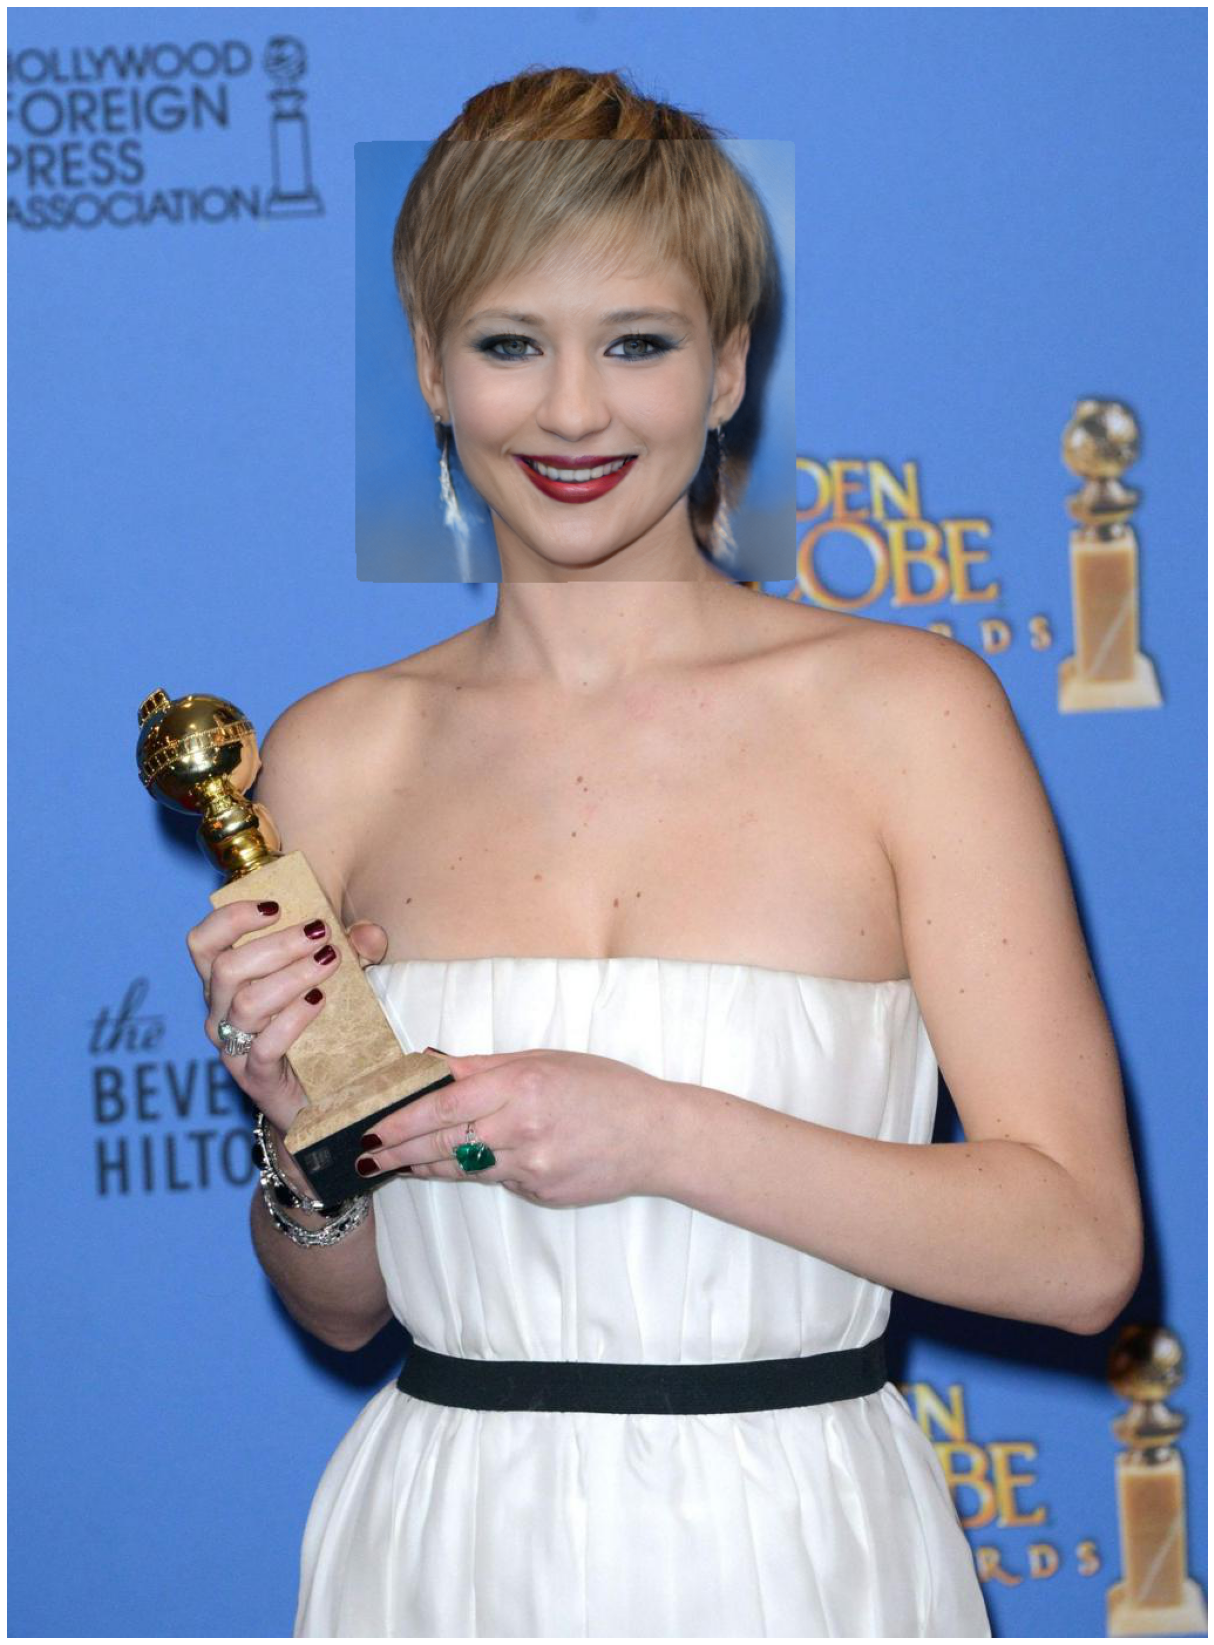

In [89]:

'''
fig = plt.figure(frameon=False, figsize=(30,30),)
ax = plt.Axes(fig, [0., 0., 1., 1.])

ax = plt.imshow(img)
plt.axis('off')

plt.savefig("weird_crop.png", bbox_inches='tight', pad_inches=0)
'''

In [ ]:
'''
crops_map = join_images(sg2latents, "/home/miguel/Desktop/TFM/database/faces/alignment/wflw/images/", 
            "/home/miguel/Desktop/TFM/StyleFlow/results/results/00000-style-changing",
            "/home/miguel/Desktop/results", plot=False, save_mask_instead=True)
'''

In [14]:
'''
crops_map = join_images(sg2latents, "/home/miguel/Desktop/TFM/database/faces/alignment/wflw/images/", 
            "/home/miguel/Desktop/TFM/StyleFlow/results/results/00000-style-changing",
            None, plot=False, save_mask_instead=True)
'''

[113 113 113 113]
[113 113 113 113]
[113 113 113 113]
None
None
None
None
None
None
[115 115 115 115]
[115 115 115 115]
[115 115 115 115]
[144 144 144 144]
[144 144 144 144]
[144 144 144 144]
None
None
None
[284 284 284 284]
[284 284 284 284]
[284 284 284 284]
None
None
None
None
None
None
None
None
None
None
None
None
[230 230 230 230]
[230 230 230 230]
[230 230 230 230]
[176 318 176 176]
[176 318 176 176]
[176 318 176 176]
None
None
None
[188 188 188 188]
[188 188 188 188]
[188 188 188 188]
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[106 106 106 106]
[106 106 106 106]
[106 106 106 106]
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[177 187 177 177]
[177 187 177 177]
[177 187 177 177]
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[90 

## Adding to the dataset


In [6]:
def find_entries(filename, file_list, file_format='jpg', only_first=False):
    to_search = filename + "." + file_format if file_format is not None else filename
    res = []
    found = False
    for file in file_list:
        if only_first and found:
            break
        with open(file, 'r') as f:
            data = json.load(f)
            for entry in data:
                if to_search in entry['imgpath']:
                    res.append(entry)
                    found = True
                    if only_first:
                        break
    
    return res

In [89]:
def overlapping_bbox(bbox1, bbox2, im=None):
    #If one rectangle is on left side of other
    if ((bbox1[0] >= bbox2[2]) or (bbox2[0] >= (bbox1[0] + bbox1[2]))):
        return False

    #If one rectangle is above other
    if ((bbox1[1] >= bbox2[3]) or (bbox2[1] >= (bbox1[1] + bbox1[3]))):
        return False
    
    dx = min(bbox1[0] + bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0])
    dy = min(bbox1[1] + bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1])
    d = dx * dy
    if d < ((bbox1[2]) * (bbox1[3]) * 0.75):
        return False
    
    return True


def generate_training_json(changed_lightning_dir, original_jsons, save_file, save_imgpath, crops, crops_map):
    all_entries = []
    last_img_name = ""
    i = 0
    dirs = listdir(changed_lightning_dir)
    dirs.sort()
    for f in dirs:
        i = i + 1
        print(i, end="\r")
        if f.endswith(".png"):
            split = f.split("_")
            join_split = "_".join(split[:-1])
            look_for = join_split + ".jpg"
            if last_img_name != look_for:
                last_img_name = look_for
                entries = find_entries(look_for, original_jsons, file_format=None, only_first=False)
            
            true_entries = []
            possible_crops = [join_split + "_" + str(x) for x in crops_map[join_split].keys()]
            for entry in entries:
                for crop_name in possible_crops:
                    if overlapping_bbox(entry['bbox'], crops[crop_name]['crop'], join(changed_lightning_dir, f)):
                        #print("Appended", entry['bbox'])
                        true_entries.append(entry)

            for entry in true_entries:
                new_entry = entry.copy()
                new_entry['imgpath'] = join(save_imgpath, f)
                all_entries.append(new_entry)
    
    print("NUM NEW EXAMPLES", len(all_entries))
                
    with open(save_file, "w") as f:
        json.dump(all_entries, f)


def join_datasets(src, dest, save):
    with open(src, 'r') as f_src:
        with open(dest, 'r') as f_dest:
            with open(save, 'w') as f_save:
                data = json.load(f_src)
                data_dest = json.load(f_dest)
                final_data = data + data_dest
                json.dump(final_data, f_save)

In [91]:
# Genera un nuevo dataset de entrenamiento
# Argumentos
# 1- Donde están las imágenes con la luz cambiada. El nombre de cada una es importante y no se debe cambiar durante todo el proceso.
# 2- El train.json original
# 3- El nuevo train.json generado con SOLO las imágenes nuevas
generate_training_json("/home/miguel/Desktop/results",
                      ['/home/miguel/Desktop/TFM/faces_py/datasets/alignments/data/wflw/train_orig.json'],
                       "/home/miguel/Desktop/TFM/faces_py/datasets/alignments/data/wflw/train_new.json",
                       "images_lightning", sg2latents['Crop'], crops_map)

NUM NEW EXAMPLES 804


In [92]:
# Une dos datasets (para unir el nuevo con el completo)
# Argumentos
# 1- un json de entrenamiento
# 2- el otro json
# 3- el json con ambos combinados
join_datasets("/home/miguel/Desktop/TFM/faces_py/datasets/alignments/data/wflw/train_new.json",
             '/home/miguel/Desktop/TFM/faces_py/datasets/alignments/data/wflw/train_orig.json',
             '/home/miguel/Desktop/TFM/faces_py/datasets/alignments/data/wflw/train.json')